# Group Project Report
# Investigating the Causes of Exercise-Induced Angina
### Cabrinha Clark, Carol Dong, Tanishka Gandhi, Astrid Zhang


## Introduction
Heart disease is the leading cause of death for both men and women of all racial and ethnic backgrounds within the United States. About 20.5 million U.S. adults have coronary artery disease, which occurs when the vessels supplying blood to your heart narrow. Exercise-induced angina, a common preset symptom of coronary artery disease, is chest pain that occurs due to reduced blood flow to the heart when an individual exercises. 

While it is good to exercise regularly, this symptom needs to be taken into consideration when deciding the right fitness plan for the individual to avoid heart disease. For example, an individual more prone to angina due to movement should lower the intensity of their cardio to avoid an episode. Our project will be performing data analysis on the cleve.mod dataset, containing test results of patients undergoing angiography at Cleveland Clinic to investigate what other factors may cause an individual to suffer exercise-induced angina, and to report our findings on this matter.

Therefore, this research will investigate the question: 
 **How do factors such as cholesterol level, maximum heart rate, ST depression, and age impact the likelihood of an individual experiencing exercise-induced angina?**



## Preliminary Exploratory Data Analysis
### Loading in libraries and the data set

In [9]:
## Loading libraries:
install.packages("themis")
install.packages("gridExtra")
install.packages("pander")
library("gridExtra")
library(tidyverse)
library(ggplot2)
library(readr)
library(tidymodels)
library(stringr)
library(themis)
library(knitr)
library(pander)
options(repr.matrix.max.rows = 6)


# Set seed to ensure reproducibility
set.seed(1)

## Hide message
show_col_types = FALSE

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Cleaning and wrangling data

In [2]:
## Clean and wrangle data 

# Set seed to ensure reproducibility
set.seed(1)
## Loading data set with a url
file_url <- "http://raw.githubusercontent.com/kakeysword/dsci100-heart-disease/main/cleve.mod"

heart_disease_data <- read_delim(url(file_url), ",", skip = 19, col_names = FALSE, show_col_types = FALSE)

## Assigning column names to the data set
heart_disease_clean <- heart_disease_data |> 
    separate(X1, into = c("age", "sex", "cp", "trestbps", "chol","fbs", 
                   "restecg", "thalach", "exang", "oldpeak", "slope", 
                   "ca", "thal", "num"), sep = "\\s+")

## Changing columns to the correct type, and replace all values of "fal" in exang column to "false" for better readablity
heart_disease_clean <- mutate_at(heart_disease_clean, 
                             c("age", "trestbps", "chol", "thalach", "oldpeak", "ca", "num"),
                            as.numeric) |>
    mutate(exang = as_factor(exang)) |> 
    mutate(exang = fct_recode(exang, "false"="fal" , "true"= "true"))|>
    select(exang, age, trestbps, chol, thalach, ca, oldpeak)

# Selecting our choosen variables 
heart_disease_final <- heart_disease_clean |> select(exang, age, chol, thalach, oldpeak)


Warning message:
“Expected 14 pieces. Additional pieces discarded in 303 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = .Primitive("as.double")(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [18]:
# Display first 6 rows of the heart disease data
cat("Figure 1.0 Cleaned Heart Disease Data\n")
pander(head(heart_disease_final), style = "grid")

Figure 1.0 Cleaned Heart Disease Data


+-------+-----+------+---------+---------+
| exang | age | chol | thalach | oldpeak |
+=======+=====+======+=========+=========+
| false | 63  | 233  |   150   |   2.3   |
+-------+-----+------+---------+---------+
| true  | 67  | 286  |   108   |   1.5   |
+-------+-----+------+---------+---------+
| true  | 67  | 229  |   129   |   2.6   |
+-------+-----+------+---------+---------+
| false | 37  | 250  |   187   |   3.5   |
+-------+-----+------+---------+---------+
| false | 41  | 204  |   172   |   1.4   |
+-------+-----+------+---------+---------+
| false | 56  | 236  |   178   |   0.8   |
+-------+-----+------+---------+---------+



### Summarizing the data

In [14]:
## Data to see number of occurences of exercise-induced angina

sum_heart_disease <- heart_disease_final |>
    group_by(exang) |>
    summarize(count = n(),
             avg_age = mean(age),         
             avg_chol = mean(chol),      
             avg_thalach = mean(thalach),
             avg_oldpeak = mean(oldpeak),
             min_age = min(age),
             min_chol = min(chol),
             min_thalach = min(thalach),
             min_oldpeak = min(oldpeak),
             max_age = max(age),
             max_chol = max(chol),
             max_thalach = max(thalach),
             max_oldpeak = max(oldpeak)) 
## Display the summary table
cat("Figure 1.1 Summary Table of the Mean, Minimum and Maximum Values of Target Variable and Predictors\n")
pander(sum_heart_disease, style = "grid")

Figure 1.1 Summary Table of the Mean, Minimum and Maximum Values of Target Variable and Predictors


+-------+-------+---------+----------+-------------+-------------+
| exang | count | avg_age | avg_chol | avg_thalach | avg_oldpeak |
+=======+=======+=========+==========+=============+=============+
| false |  204  |  53.75  |  243.8   |    155.7    |   0.8069    |
+-------+-------+---------+----------+-------------+-------------+
| true  |  99   |  55.63  |  251.2   |    137.2    |    1.519    |
+-------+-------+---------+----------+-------------+-------------+

Table: Table continues below

 

+---------+----------+-------------+-------------+---------+----------+
| min_age | min_chol | min_thalach | min_oldpeak | max_age | max_chol |
+=========+==========+=============+=============+=========+==========+
|   29    |   126    |     71      |      0      |   76    |   564    |
+---------+----------+-------------+-------------+---------+----------+
|   35    |   131    |     88      |

### Visualizing the data

Warning message:
“Removed 5 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


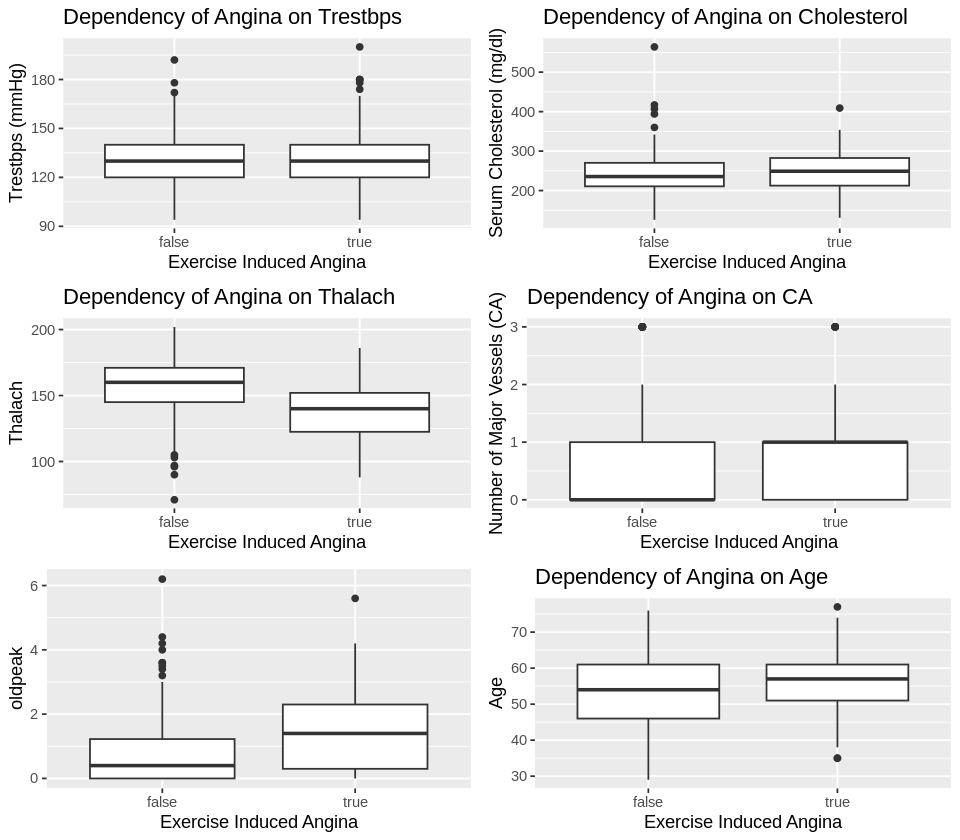

In [16]:
## Create plots to visualize data

par(mfrow = c(2, 3))

#boxplot for trestbps
options(repr.plot.width = 8, repr.plot.height = 7)

trestbps_plot <- heart_disease_clean |>
    ggplot(aes(y = trestbps, x = exang)) +
    geom_boxplot() +
    labs(y = "Trestbps (mmHg)", x = "Exercise Induced Angina", title = "Dependency of Angina on Trestbps")

#boxplot for cholesterol
chol_plot <- heart_disease_clean |>
    ggplot(aes(y = chol, x = exang)) +
    geom_boxplot() +
    labs(y = "Serum Cholesterol (mg/dl)", x = "Exercise Induced Angina", title = "Dependency of Angina on Cholesterol")


#boxplot for thalach
thalach_plot <- heart_disease_clean |>
    ggplot(aes(y = thalach, x = exang)) +
    geom_boxplot() +
    labs(y = "Thalach", x = "Exercise Induced Angina", title = "Dependency of Angina on Thalach")

#boxplot for ca
ca_plot <- heart_disease_clean |>
    ggplot(aes(y = ca, x = exang)) +
    geom_boxplot() +
    labs(y = "Number of Major Vessels (CA)", x = "Exercise Induced Angina", title = "Dependency of Angina on CA")

#boxplot for oldpeak 
oldpeak_plot <- heart_disease_clean |>
    ggplot(aes(y = oldpeak, x = exang)) +
    geom_boxplot() +
    labs(y = "oldpeak", x = "Exercise Induced Angina")

#boxplot for age 
age_plot <- heart_disease_clean |>
    ggplot(aes(y = age, x = exang)) +
    geom_boxplot() +
    labs(y = "Age", x = "Exercise Induced Angina", title = "Dependency of Angina on Age")

## Grid of all box plots comparing target variables and potential predictors
grid.arrange(trestbps_plot, chol_plot, thalach_plot, ca_plot, oldpeak_plot, age_plot)

## Building the K Classification Model
### Splitting and Upsampling the Data

In [17]:
## Setting seed to ensure reproducibility
set.seed(1)

## Splitting the data into training and testing
heart_disease_split <- initial_split(heart_disease_final, prop = 0.75, strata = exang)

heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

# Upsampling the data
ups_recipe <- recipe(exang ~ age + chol+ thalach + oldpeak, data = heart_disease_train) |>
    step_upsample(exang, over_ratio = 1, skip = FALSE) |>
    prep()

upsampled_heart_train <- bake(ups_recipe, heart_disease_train)

## cross-validation method

# add vfold
heart_vfold <- vfold_cv(heart_disease_train, v = 10, strata = exang)
vals <- tibble(neighbors = seq(from = 1, to = 10, by =1))


heart_recipe <- recipe(exang ~ age + chol + thalach + oldpeak, data = upsampled_heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

standardized_heart_data <- bake(heart_recipe, upsampled_heart_train)

# check our standard data
heart_proportions <- standardized_heart_data|>
                      group_by(exang) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(upsampled_heart_train))
cat("Figure 1.2 Summary Table of Upsampled Heart Disease Training Data\n")
pander(heart_proportions, style = "grid")

Figure 1.2 Summary Table of Upsampled Heart Disease Training Data


+-------+-----+---------+
| exang |  n  | percent |
+=======+=====+=========+
| false | 153 |   50    |
+-------+-----+---------+
| true  | 153 |   50    |
+-------+-----+---------+



### Determining the Best K-Value

Best K value


[1] 7

Figure 1.3 Metrics Table for K = 10


+-----------+----------+------------+--------+----+---------+
| neighbors | .metric  | .estimator |  mean  | n  | std_err |
+===========+==========+============+========+====+=========+
|     1     | accuracy |   binary   | 0.627  | 10 | 0.03174 |
+-----------+----------+------------+--------+----+---------+
|     2     | accuracy |   binary   | 0.627  | 10 | 0.03174 |
+-----------+----------+------------+--------+----+---------+
|     3     | accuracy |   binary   | 0.6923 | 10 | 0.02083 |
+-----------+----------+------------+--------+----+---------+
|     4     | accuracy |   binary   | 0.6923 | 10 | 0.02083 |
+-----------+----------+------------+--------+----+---------+
|     5     | accuracy |   binary   | 0.7097 | 10 | 0.02353 |
+-----------+----------+------------+--------+----+---------+
|     6     | accuracy |   binary   | 0.7097 | 10 | 0.02353 |
+-----------+----------+------------+--------+----+---------+
|     7     | accuracy |   binar

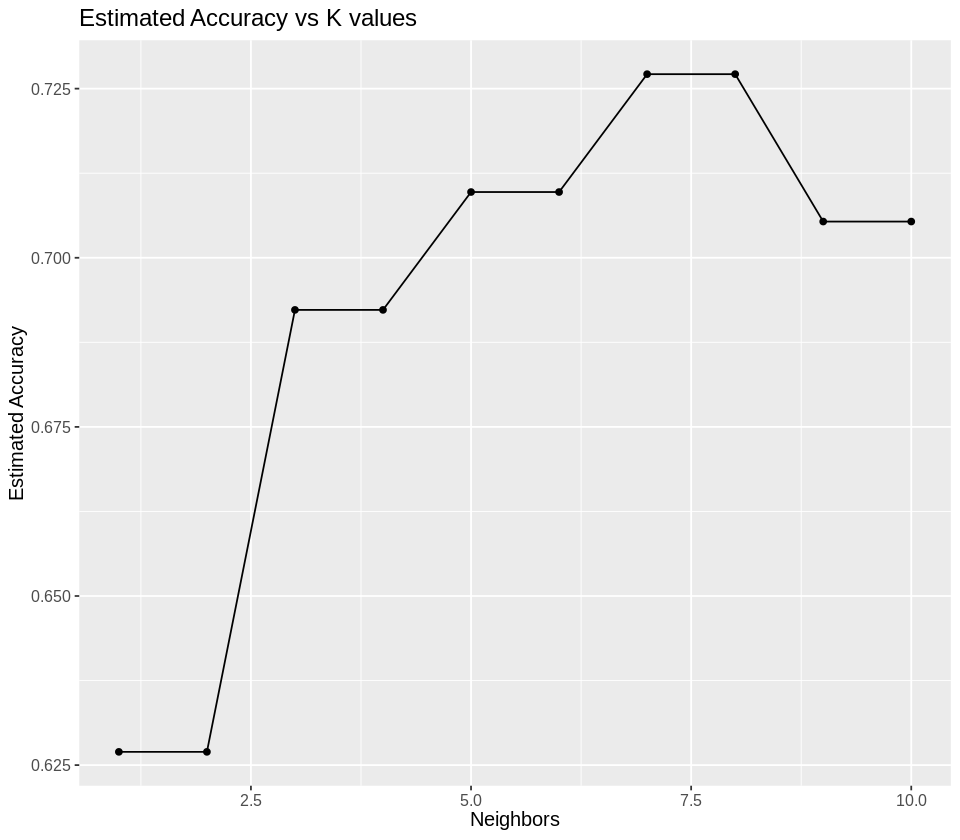

In [23]:
#heart spec
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

# Workflow
vfold_metrics <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec_2) |>
    tune_grid(resamples = heart_vfold, grid = vals) |>
    collect_metrics()|>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(vfold_metrics, aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    labs(x = "Neighbors", y = "Estimated Accuracy") + 
    ggtitle("Estimated Accuracy vs K values") +
    theme(text = element_text(size = 12))
accuracy_vs_k

best_k <- vfold_metrics |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
cat("Best K value\n")
best_k

cat("Figure 1.3 Metrics Table for K = 10\n")
pander(vfold_metrics, style = "grid")

### Performing KNN Classification with the Best K Value

In [41]:

#knn_spec with new k-value 
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
set_engine("kknn") |>
set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec_2) |>
    fit(data = heart_disease_train)

#prediction
heart_test_predictions <- predict(knn_fit, heart_disease_test) |>
    bind_cols(heart_disease_test)

heart_model_accuracy <- heart_test_predictions |>
    metrics(truth = exang, estimate = .pred_class)|>
    filter(.metric == "accuracy")

# "first" is referring to "false" cases
# Predictions of "false" cases

heart_test_false_precision <- heart_test_predictions |>
    precision(truth = exang, estimate = .pred_class, event_level = "first")

heart_test_false_recall <- heart_test_predictions |>
    recall(truth = exang, estimate = .pred_class, event_level = "first")

# Predictions of "true" cases
heart_test_true_precision <- heart_test_predictions |>
    precision(truth = exang, estimate = .pred_class, event_level = "second")

heart_test_true_recall <- heart_test_predictions |>
    recall(truth = exang, estimate = .pred_class, event_level = "second")

# Heart Test Predictions
heart_test_predictions

## Display all tables

cat("Figure 2.0 Classification Model Accuracy")
pander(heart_model_accuracy, style="grid")

cat("Figure 2.1 Recall of False Cases")
pander(heart_test_false_recall, style = "grid")

cat("Figure 2.2 Precision of False Cases")
pander(heart_test_false_precision, style = "grid")

cat("Figure 2.3 Recall of True Cases")
pander(heart_test_true_recall, style = "grid")

cat("Figure 2.4 Precision of True Cases")
pander(heart_test_true_precision, style = "grid")

# Confusion matrix for heart disease predictions
confusion <- heart_test_predictions |>
    conf_mat(truth = exang, estimate = .pred_class)

cat("Figure 3.0 Confusion Matrix")
confusion


.pred_class,exang,age,chol,thalach,oldpeak
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
false,false,41,204,172,1.4
false,false,56,236,178,0.8
true,false,62,268,160,3.6
⋮,⋮,⋮,⋮,⋮,⋮
true,false,58,248,122,1
false,false,48,255,175,0
false,false,54,201,163,0


Figure 2.0 Classification Model Accuracy

+----------+------------+-----------+
| .metric  | .estimator | .estimate |
+==========+============+===========+
| accuracy |   binary   |  0.6447   |
+----------+------------+-----------+

Figure 2.1 Recall of False Cases

+---------+------------+-----------+
| .metric | .estimator | .estimate |
+=========+============+===========+
| recall  |   binary   |  0.7255   |
+---------+------------+-----------+

Figure 2.2 Precision of False Cases

+-----------+------------+-----------+
|  .metric  | .estimator | .estimate |
+===========+============+===========+
| precision |   binary   |   0.74    |
+-----------+------------+-----------+

Figure 2.3 Recall of True Cases

+---------+------------+-----------+
| .metric | .estimator | .estimate |
+=========+============+===========+
| recall  |   binary   |   0.48    |
+---------+------------+-----------+

Figure 2.4 Precision of True Cases

+-----------+------------+-----------+
|  .metric  | .estim

          Truth
Prediction false true
     false    37   13
     true     14   12

### Visualization of the Analysis

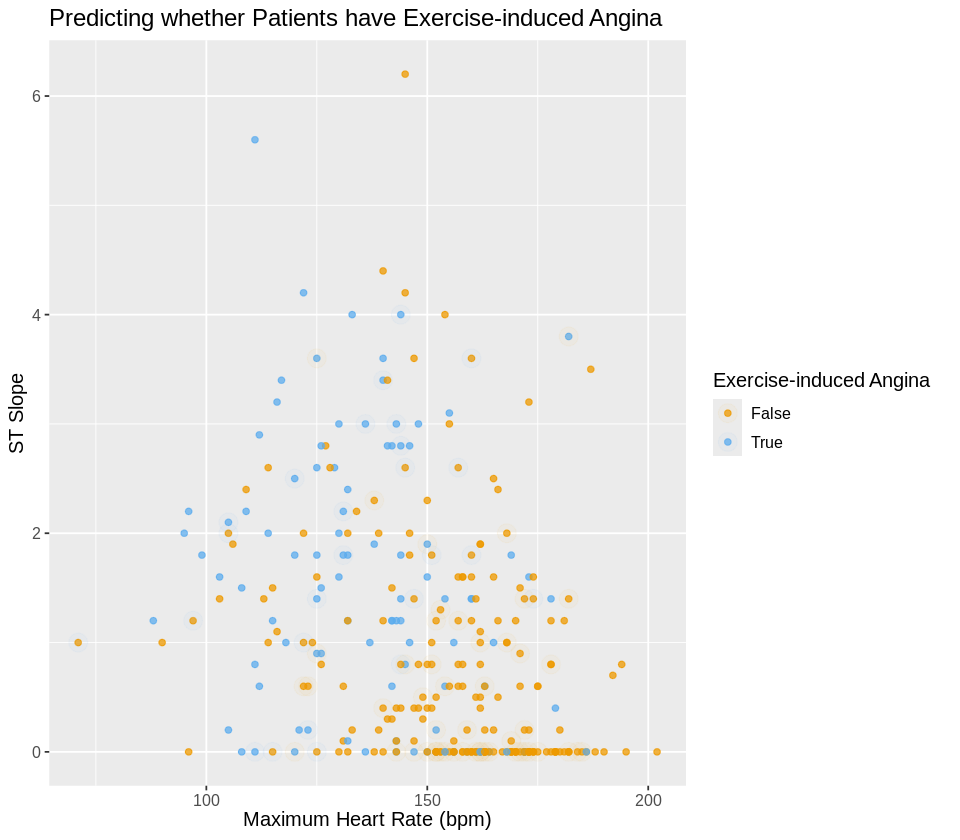

In [65]:
prediction_plot <-
  ggplot() +
  geom_point(data = heart_disease_final, 
             mapping = aes(x = thalach, 
                           y = oldpeak, 
                           color = exang), 
             alpha = 0.75) +
  geom_point(data = heart_test_predictions, 
             mapping = aes(x = thalach, 
                           y = oldpeak, 
                           color = .pred_class), 
             alpha = 0.04, 
             size = 5) +
  labs(color = "Exercise-induced Angina", 
       x = "Maximum Heart Rate (bpm)", 
       y = "ST Slope") +
  scale_color_manual(labels = c("False", "True"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))+ 
    ggtitle("Predicting whether Patients have Exercise-induced Angina")

prediction_plot

## Methods
After loading in the necessary libraries, we loaded in the `cleve.mod` data set from the Heart Disease Database, which contains data taken from patients at the Cleveland Clinic in Cleveland Ohio.
Our data analysis will be preparing to perform a classification to determine whether a new patient is likely to experience exercise-induced angina.
We are using `exang` (exercised-induced angina) as our classification variable, and the following 4 columns as the predictors: `age, chol, thalach, oldpeak`. <br><br>
`exang` : Exercise induced angina (true or false) <br>
`age` : Age in years <br>
`chol` : Serum Cholesterol (mg/dl) <br>
`thalach` : Maximum Heart Rate <br>
`oldpeak` : Slope of the Peak Exercise ST Segment <br>

When cleaning the data, we made sure to separate the data into individual columns, and convert them into the correct type (e.g. numeric for numerical variables) as everything was of type `character` when the data set was first loaded in. <br> <br>

#### Visualizing the data
In order to select the predictors used within our model, we created boxplots for each numeric variable supplied within the data: `age, chol, thalach, oldpeak, ca, trestbps`. <br><br>

We visually analyzed the boxplots to see how much spread and variance there was between the true and false categories of our data (whether angina was experienced). These graphs suggested that the predictors age, thalach and oldpeak are the best variables to use for our model, as a larger difference indicates a more significant influence of that variable. Our group also chose to include the cholesterol variable, as our research beyond the data proposes that this should affect heart health and whether exercise induced angina is experienced. <br> <br>

#### Summarizing the data
When summarizing the data, we grouped the training dataset by `exang`, and then found the number of patients that did or did not experience exercise-induced angina, and also found the mean, minimum and maximum value for each predictor. <br> <br>
**Our Findings:**<br>
After summarizing the data, we noticed an imbalance in the number of cases of patients that experienced exercise-induced angina compared to those that did not. We took this into account and upsampled the training data to ensure that all observations contribute equally in our classification model. <br> <br>

Observing our table it seems that on average, individuals that experience exercise induced angina tend to be older in age and have a higher cholesterol and ST slope value than those that do not. This follows with the minimum and maximum age being higher in patients with experience exercise induced angina, along with them having higher minimum and maximum serum cholesterol levels. Additionally, patients that experience exercise induced angina were found to have a lower maximum heart rate, but a higher minimum heart rate. Interestingly, the minimum ST slope value of zero is common in both patients that did and did not experience exercise induced angina.


#### Building our K Classification Model
We decided to perform our analysis with K-Nearest Neighbors since we are trying to predict a categorical value. To begin building our knn classification model, the data was split into 75% training and 25% testing dataset. 
<br> <br>
Within our recipe that uses our training data and chosen predictors, we also upsampled the training data. After observing an imbalance in true and false observations in the original data, we needed to modify the training data to remove biases that would result in our classification model. This will allow for a more even distribution of predictions, so both classes (true/false angina) are evenly represented within the model. 

#### Performing Cross Validation
The summary table heart_proportions was created in order to double-check that our training data was indeed upsampled, and that both observations of true and false were balanced. <br><br>
After baking the recipe with the upsampled training data, cross validation was performed withthe vfold) function to create 10 different subsets of the training data, which allowed us to see what K-value from 1 to 10 would produce the most accurate model. Since we performed K classification, we usedthe tune) function and set the engine and mode to “kknn” and “classification” respectivle. .Since we used accuracy as a metric to determine what k value to use, a plot was generated of the estimated accuracy for each k value vs all 10 k value.
r<br> The k value with the highest estimated accuracy was chosen as our best k value, which in this case was a value of =7. <rb.
#### Building and Testing the Performance of our ClassifierWe also standardized the data to ensure that all observations would be on a comparable scale and contribute equally to the calculation of the distance between data points.
<br><br>
Next, we created a second recipe with the upsampled data. We scaled and centered this data to guarantee that all variables are equally weighted, and then used prep() and bake() to process our data.<b

FrFinally, we performed KNN classification, setting the number of neighbors to 7, and built a workflow using our second recipe containing the upsampled training data. We predicted the testing data with our workflow, and collected metrics about accuracy, recall and precision for both true and false cases, as well as created a confusion matrix in order to judge the performance of our classifr.





## Expected Outcomes and Significance
**Summarizing what we found:**

After performing KNN classification with the testing data, we found that our classifier has an accuracy of 64.47%. It has a precision and recall of 74.00% and 72.55% respectively when predicting false cases, and a precision and recall of 46.15% and 48.00% for true cases. <br><br>
From our confusion matrix, we found that 37 false observations were correctly predicted as false, and that 12 observations were correctly predicted as positive. However, the classifier made mistakes that can be observed in the 14 true cases that were predicted as false, and the 13 false cases that were mistakenly predicted as true. <br> <br>
Examining the difference in the precision and recall for false and true cases, we found that our classifier works significantly better for predicting patients who do not experience exercise induced angina in contrast to prediction patients that do. Since the precision and recall of our classifier falls below 50% when predicting positive cases, then it is unlikely to be useful in real life applications. What we found from this is that perhaps the predictors chosen were not effective for this particular dataset in differentiating who has exercise-induced angina versus those that do not. To a certain extent, a low accuracy was expected as one of the predictors, cholesterol, was chosen based on external research instead of the boxplot analysis as the research claimed high cholesterol would decrease blood flow to the heart decreasing the amount of O2 which would induce exercise angina. Given the low performance of the classifier, this suggests that perhaps KNN classification is not the most effective model for this type of data, and that there may be other variables not given in this dataset that have a heavier influence on our target variable. 

**What we expected to find：**  
For our first variable, age, we expect to see a positive relationship between age and anginal pain. Scientific studies prove that as humans age, the level of oxygen concentration within the blood decreases. For serum cholesterol, higher blood cholesterol concentration is associated with less oxygen transport within the blood. Therefore, we expect to find higher serum cholesterol levels among patients that have experienced exercise-induced angina. Maximum heart rate indicates the demand for blood and oxygen of the heart. We expect to find a positive correlation between each predictive variable and the number of individuals experiencing exercise-induced angina.

**The impact of our findings：** 
Many doctors recommend exercise for various types of medical concerns. Our research findings could influence doctors to offer safer remedies to their patients. For example, prior to recommending high-intensity exercise to their patients, a medical professional can consider the four predictive variables within our study to analyze how susceptible the patient is to heart pain during movement. This could decrease the risk of a patient experiencing exercise-induced angina by prescribing a lower intensity plan. These findings also allow for better diet planning and lifestyle planning allowing an individual to take preventative measures to avoid the onset of exercise-induced angina.  
**Future questions this could lead to:**
* How effective would maintaining a lower cholesterol level and heart rate be towards preventing exercise-induced angina? <br>

* What alternative machine learning techniques could be explored to enhance predictive accuracy for exercise-induced angina using the same predictors? <br>
* What other factors could be strong indicators that an individual is susceptible to experiencing angina? <br>


## Bibliography
Ramires, Jose, et al. Cholesterol Lowering with Statins Reduces Exercise-Induced Myocardial Ischemia  in Hypercholesterolemic Patients with Coronary Artery Disease. American Journal of Cardiology,  15 Nov. 2001<br><br>
Li, Zhuoning, et al. Determining which physical parameters are significant for heart disease. IOP  Publishing, 202<br?<br>
. 

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X. 
<br><br>
Buchwald H, O'Dea TJ, Menchaca HJ, Michalek VN, Rohde TD. Effect of plasma cholesterol on red blood cell oxygen transport. Clin Exp Pharmacol Physiol. 2000 Dec;27(12):951-5. doi: 10.1046/j.1440-1681.2000.03383.x. PMID: 11117230.<br><br>
Cunha, John P., editor. "What Is a Good Oxygen Rate by Age?" emedicinehealth,  www.emedicinehealth.com/what_is_a_good_oxygen_rate_by_age/article_em.htm <br><br>
Beckett N, Nunes M, Bulpitt C. Is it advantageous to lower cholesterol in the elderly hypertensive? Cardiovasc Drugs Ther. 2000 Aug;14(4):397-405. doi: 10.1023/a:1007812232328. PMID: 10999646.<br><br>
Crooks CJ, West J, Morling J, Simmonds M, Juurlink I, Briggs S, Cruickshank S, Hammond-Pears S, Shaw D, Card T, Fogarty AW. Inverse association between blood pressure and pulse oximetry accuracy: an observational study in patients with suspected or confirmed COVID-19 infection. Emerg Med J. 2023 Mar;40(3):216-220. doi: 10.1136/emermed-2022-212443. Epub 2022 Dec 7. PMID: 36600468. <br><br>
Schantz P, Salier Eriksson J, Rosdahl H. The heart rate method for estimating oxygen uptake: analyses of reproducibility using a range of heart rates from commuter walking. Eur J Appl Physiol. 2019 Dec;119(11-12):2655-2671. doi: 10.1007/s00421-019-04236-0. Epub 2019 Oct 18. PMID: 31628539; PMCID: PMC6858472. <br><br>
Medical News Today. www.medicalnewstoday.com/articles/does-exercise-lower-cholesterol#:~:text=According%20to%20the%20AHA%2C%20150,also%20help%20raise%20HDL%20cholesterol. Accessed 9 Mar. 2024. <br><br>
"What Is Coronary Heart Disease." National Heart, Lung, and Blood Institute, www.nhlbi.nih.gov/health/coronary-heart-disease#:~:text=About%2020.5%20million%20U.S.%20adults,the%20surface%20of%20the%20heart. Accessed 9 Mar. 2024. 

